In [1]:
# imports:  
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import psutil
torch.manual_seed(0);

### Import and Plotting Data

In [2]:
train_data = pd.read_csv('energy_train.csv')
test_data = pd.read_csv('energy_test.csv')

In [3]:
x_train = torch.tensor(train_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_train = torch.tensor(train_data[['W']].values).float()
x_test = torch.tensor(test_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_test = torch.tensor(test_data[['W']].values).float()

In [4]:
# Splitting x_train and y_train into 3 sets of 200 each
UT_x = x_train[:200]
UT_y = y_train[:200]

SS_x = x_train[200:400]
SS_y = y_train[200:400]

BT_x = x_train[400:600]
BT_y = y_train[400:600]

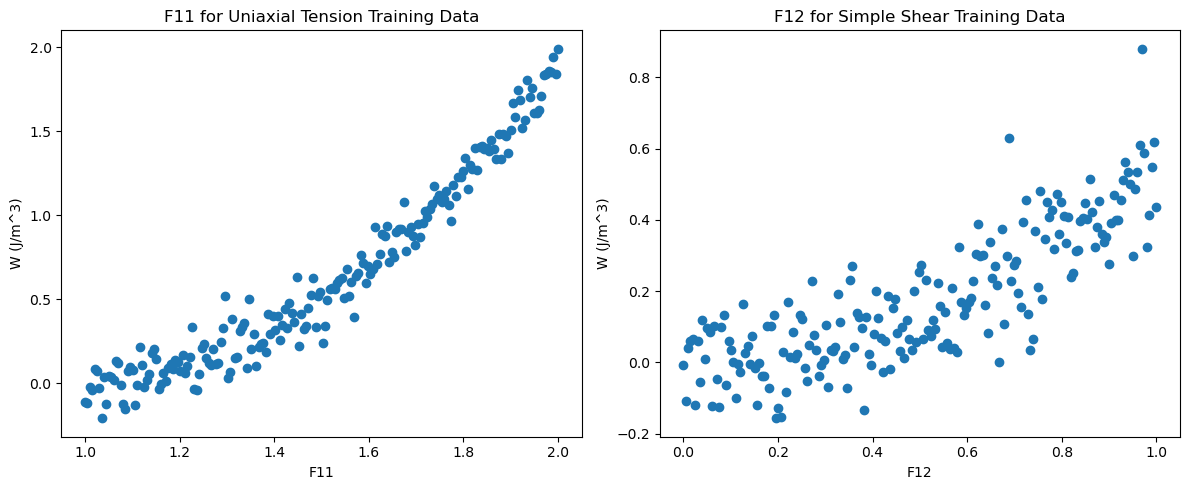

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot F11 for UT and BT against W
axes[0].scatter(UT_x[:, 0].numpy(), UT_y.numpy(), label='UT')
axes[0].set_title('F11 for Uniaxial Tension Training Data')
axes[0].set_xlabel('F11')
axes[0].set_ylabel('W (J/m^3)')

# Plot F12 for SS against W
axes[1].scatter(SS_x[:, 1].numpy(), SS_y.numpy(), label='SS')
axes[1].set_title('F12 for Simple Shear Training Data')
axes[1].set_xlabel('F12')
axes[1].set_ylabel('W (J/m^3)')

# Adjust layout
plt.tight_layout()
#plt.savefig('Train.png')

# Show the plots
plt.show()

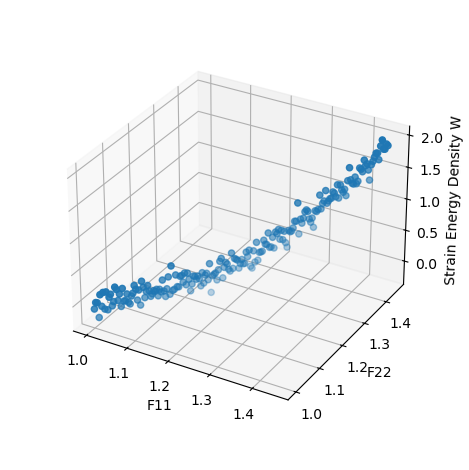

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(BT_x[:,0].numpy(), BT_x[:,4].numpy(), BT_y.numpy(), label='Biaxial Tension Training Data')
ax.set_xlabel('F11')
ax.set_ylabel('F22')
ax.set_zlabel('Strain Energy Density W')
#ax.legend()
ax.dist = 8
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.tight_layout()

plt.show()

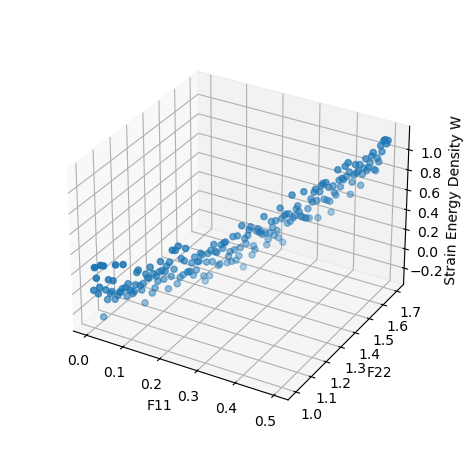

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_test[:,2].numpy(), x_test[:,4].numpy(), y_test.numpy(), label='Uniaxial-Shear Combined Test Data')
ax.set_xlabel('F11')
ax.set_ylabel('F22')
ax.set_zlabel('Strain Energy Density W')
#ax.legend()
ax.dist = 8
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.tight_layout()

plt.show()

### Naive Neural Network

In [8]:
naive_nn = torch.nn.Sequential(
    torch.nn.Linear(9,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,1)
)

#----------------------------------------------
print('Inverse design neural network:\n\n',naive_nn)

Inverse design neural network:

 Sequential(
  (0): Linear(in_features=9, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=1, bias=True)
)


### Implementing ICNN and Training Model

In [9]:
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.001

# Optimizer: use Adam
optimizer = torch.optim.Adam(naive_nn.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = nn.MSELoss()

# number of steps, the proper term is 'EPOCH'
num_epochs = 5000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = naive_nn(x_train)
    # Compute the loss.
    train_loss = loss_function(y_train_pred, y_train)
    
    # Store the loss in a list
    train_loss_history.append(train_loss.item())
    
    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad():
        # Make your predictions
        y_test_pred = naive_nn(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        # Store the loss in a list
        test_loss_history.append(test_loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train loss: {train_loss.item()}')
        print(f'Test loss: {test_loss.item()}')
        print('----------------------------------------')

Epoch [1/5000]
Train loss: 0.6161089539527893
Test loss: 0.3422512710094452
----------------------------------------
Epoch [1001/5000]
Train loss: 0.010182170197367668
Test loss: 0.01214362308382988
----------------------------------------
Epoch [2001/5000]
Train loss: 0.010079365223646164
Test loss: 0.013807934708893299
----------------------------------------
Epoch [3001/5000]
Train loss: 0.01006255578249693
Test loss: 0.01445823535323143
----------------------------------------
Epoch [4001/5000]
Train loss: 0.010056579485535622
Test loss: 0.014206621795892715
----------------------------------------


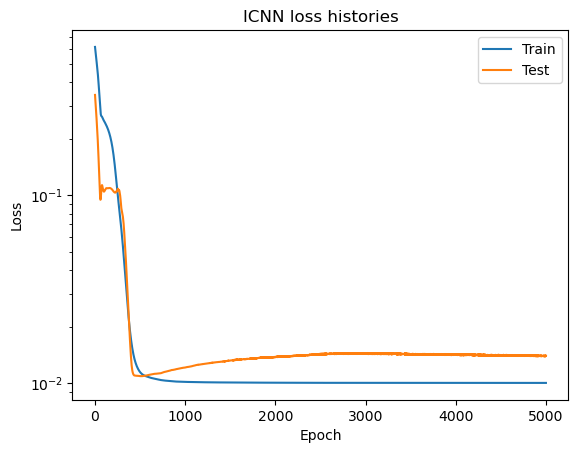

In [10]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.title('ICNN loss histories');
#plt.savefig('Loss Histories.png')

In [11]:
def calculate_R2(true, pred):
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_strainenergy(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()], color='r')
        ax.set_title('W: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    #plt.savefig('R2.png')
    fig.tight_layout()

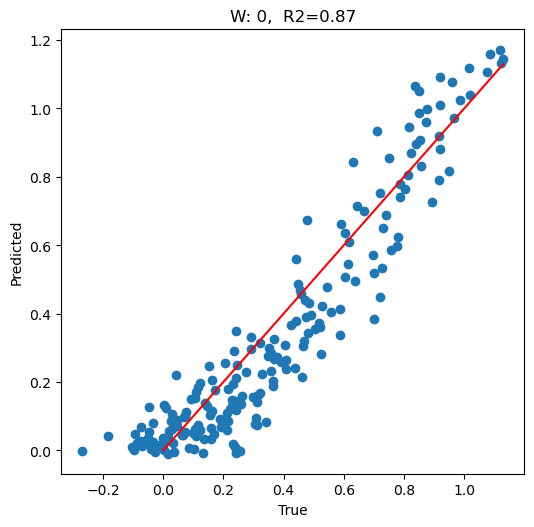

In [12]:
with torch.no_grad():
    y_test_pred = naive_nn(x_test)

# Visualize accuracy
plotR2_strainenergy(y_test, y_test_pred)

### Verification of Results

In [13]:
F11_test = x_test[:, 0].numpy()
F12_test = x_test[:, 1].numpy()
F13_test = x_test[:, 2].numpy()
F21_test = x_test[:, 3].numpy()
F22_test = x_test[:, 4].numpy()
F23_test = x_test[:, 5].numpy()
F31_test = x_test[:, 6].numpy()
F32_test = x_test[:, 7].numpy()
F33_test = x_test[:, 8].numpy()

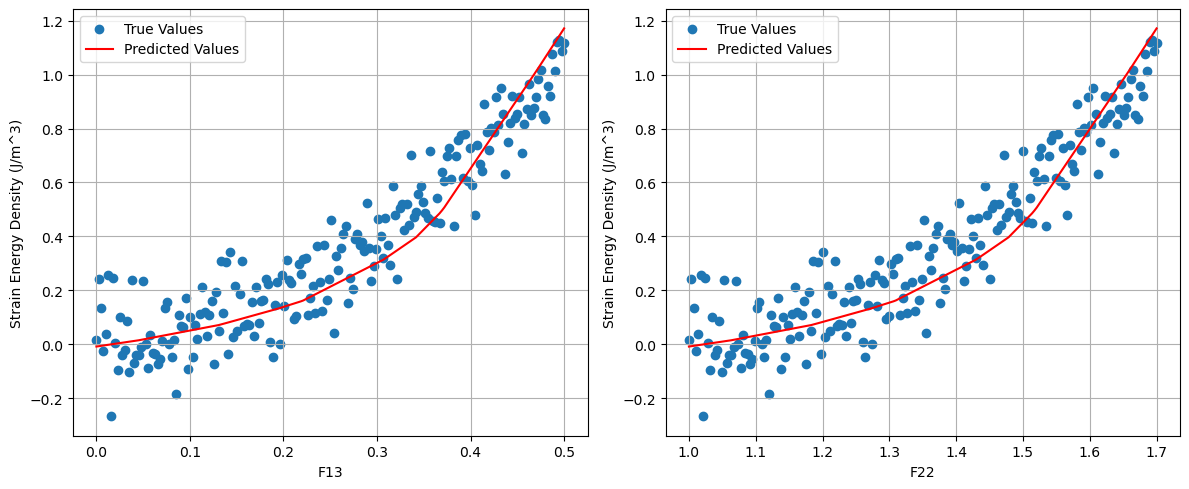

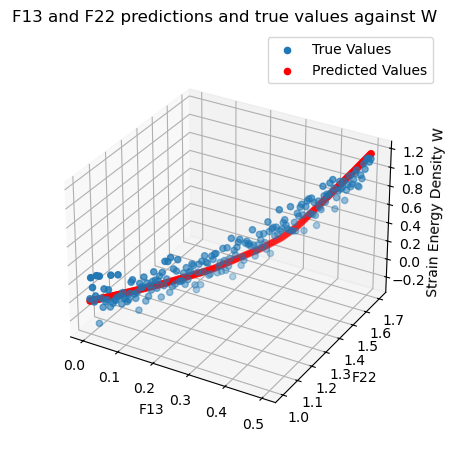

In [14]:
# Make plots for all other F values
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axes[0].scatter(F13_test, y_test, label='True Values')
axes[0].plot(F13_test, y_test_pred, label='Predicted Values', color='red')
axes[0].set_xlabel('F13')
axes[0].set_ylabel('Strain Energy Density (J/m^3)')
axes[0].legend()
axes[0].grid(True)

# Plot for F22
axes[1].scatter(F22_test, y_test, label='True Values')
axes[1].plot(F22_test, y_test_pred, label='Predicted Values', color='red')
axes[1].set_xlabel('F22')
axes[1].set_ylabel('Strain Energy Density (J/m^3)')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_pred.png')

# Show combined plot
plt.show()

# Plot for F13 and F22 predictions and true values against W
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(F13_test, F22_test, y_test, label='True Values')
ax.scatter(F13_test, F22_test, y_test_pred, label='Predicted Values', color='red')
ax.set_xlabel('F13')
ax.set_ylabel('F22')
ax.set_zlabel('Strain Energy Density W')
ax.legend()
ax.dist = 8
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.title('F13 and F22 predictions and true values against W')
# fit z axes label within plot. it's going outside the border
plt.tight_layout()

plt.show()

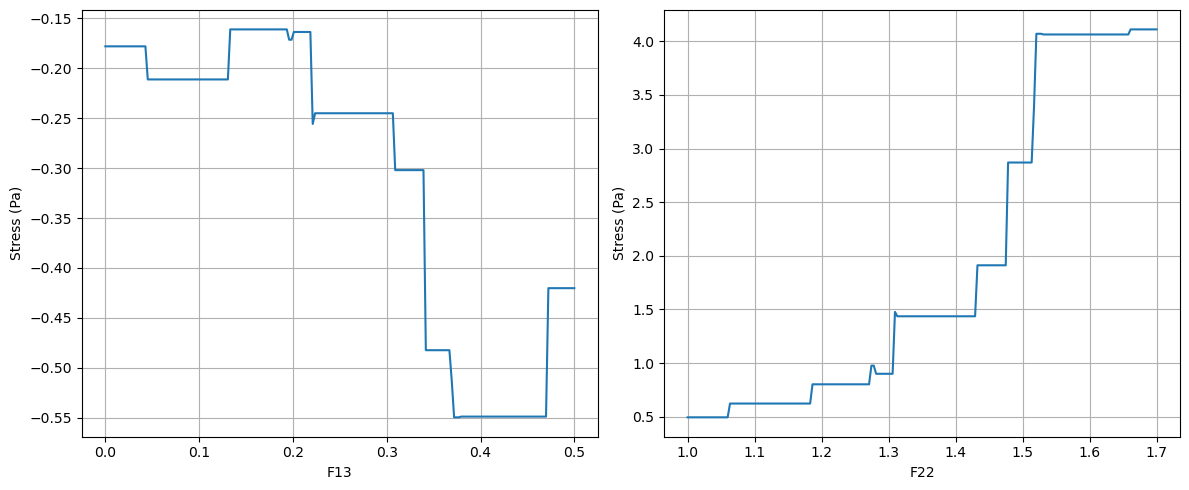

In [15]:
# Compute the gradient of the predicted values with respect to the input on F13 and F22 and plot it
x_test.requires_grad_(True)
y_test_pred = naive_nn(x_test)
grad = torch.autograd.grad(outputs=y_test_pred, inputs=x_test, grad_outputs=torch.ones_like(y_test_pred), create_graph=True)[0]

#Combine the above two plots using subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axs[0].plot(F13_test, grad[:, 2].detach().numpy())
axs[0].set_xlabel('F13')
axs[0].set_ylabel('Stress (Pa)')
axs[0].grid(True)

# Plot for F22
axs[1].plot(F22_test, grad[:, 4].detach().numpy())
axs[1].set_xlabel('F22')
axs[1].set_ylabel('Stress (Pa)')
axs[1].grid(True)
# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_gradient.png')

# Show combined plot
plt.show()

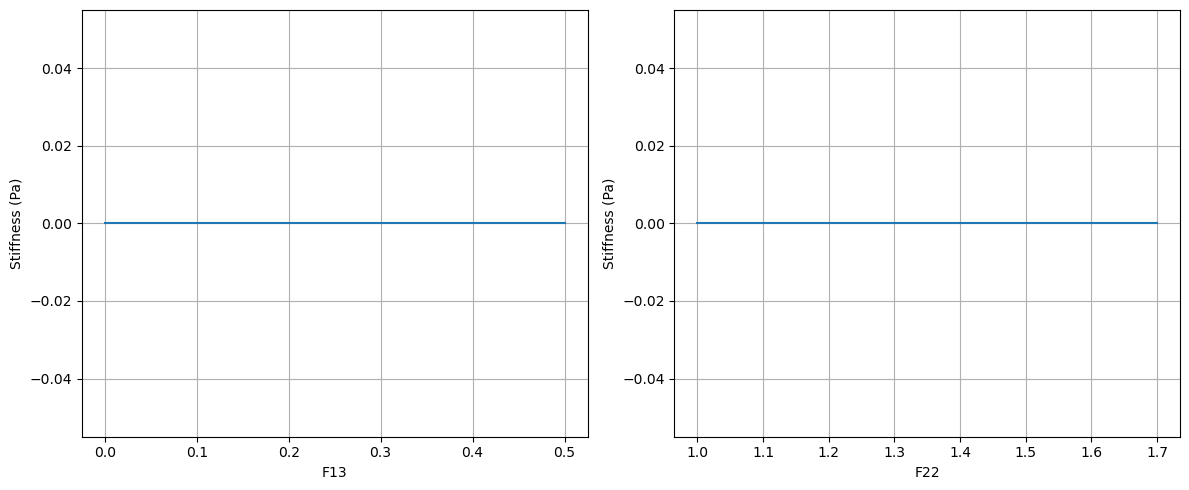

In [16]:
x_test.requires_grad_(True)
y_test_pred = naive_nn(x_test)
der1 = torch.autograd.grad(outputs=y_test_pred, inputs=x_test, grad_outputs=torch.ones_like(y_test_pred), create_graph=True)[0]
der2 = torch.autograd.grad(outputs=der1, inputs=x_test, grad_outputs=torch.ones_like(der1), create_graph=True)[0]

#plot der2 against F13 and F22
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axs[0].plot(F13_test, der2[:, 2].detach().numpy())
axs[0].set_xlabel('F13')
axs[0].set_ylabel('Stiffness (Pa)')
axs[0].grid(True)

# Plot for F22
axs[1].plot(F22_test, der2[:, 4].detach().numpy())
axs[1].set_xlabel('F22')
axs[1].set_ylabel('Stiffness (Pa)')
axs[1].grid(True)
# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_second_derivative.png')

# Show combined plot
plt.show()

In [17]:
# Print total computational time and resources used
print('Total computational time: ', time.process_time(), 'seconds')
print('Total memory used: ', psutil.virtual_memory().percent, '%')

Total computational time:  11.9375 seconds
Total memory used:  54.7 %
